# Preparing Data for CAPTCHA Classification

This cell prepares the dataset for training a separate classifier for each position in the CAPTCHA:

- **Imports**: Libraries such as `fastai.vision.all` for building models, `pandas` for handling tabular data, `Pathlib` for filesystem operations, and `PIL` for image verification.
- **Image Validation**: Iterates through all `.png` images in the specified dataset directory, verifying their integrity using PIL. Corrupted files are identified and skipped.
- **DataFrame Creation**: A DataFrame is created where:
  - The `image` column stores paths to valid images.
  - Additional columns (`label_1` to `label_5`) store the respective character at each CAPTCHA position (or 'X' if the position exceeds the length of the CAPTCHA).
- **Summary**: Outputs the total count of valid images after validation.

This step ensures a clean and structured dataset for training position-specific classifiers.


In [ ]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm

path = Path('../../data')

valid_images = []
for img_path in path.glob('*.png'):
    try:
        with Image.open(img_path) as img:
            img.verify()
        valid_images.append(img_path)
    except (IOError, SyntaxError):
        print(f"Corrupted file skipped: {img_path}")

df = pd.DataFrame({'image': valid_images})
for i in range(5):
    df[f'label_{i+1}'] = df['image'].apply(lambda x: x.stem[i] if i < len(x.stem) else 'X')

print(f"Total valid images: {len(valid_images)}")

Corrupted file skipped: /kaggle/input/large-captcha-dataset/Large_Captcha_Dataset/4q2wA.png
Total valid images: 82328


# Training and Saving Models for CAPTCHA Character Positions

This cell defines and trains separate classifiers for each character position in the CAPTCHA:

- **Imports**: Includes modules for building data loaders, defining transformations, and creating image classifiers (`resnet50`).

- **`train_and_save_character_model` Function**:
  - Creates an `ImageDataLoaders` object from the DataFrame for a specific character position (`label_{position+1}`).
  - Preprocesses images with resizing and normalization transformations.
  - Builds a CNN model using a `resnet50` architecture with `accuracy` as the evaluation metric.
  - Fine-tunes the model for 15 epochs and saves it to the specified path, naming the model file according to the character position.

- **Model Training Loop**:
  - Iterates over all 5 character positions in the CAPTCHA.
  - Trains a separate model for each position using the `train_and_save_character_model` function.
  - Saves the trained models in a designated directory.

- **Result**: A list of trained models, one for each CAPTCHA character position, is created and saved for later use in prediction.

In [ ]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Resize, Normalize, imagenet_stats, vision_learner, resnet50, accuracy
from tqdm import tqdm

def train_and_save_character_model(position, save_path):
    dls = ImageDataLoaders.from_df(
        df, 
        path='../../', 
        fn_col='image', 
        label_col=f'label_{position+1}', 
        item_tfms=Resize((77, 247)), 
        batch_tfms=[Normalize.from_stats(*imagenet_stats)],
        bs=64
    )
    
    learn = vision_learner(dls, resnet50, metrics=accuracy)
    learn.fine_tune(15)
    
    model_path = save_path / f"captcha_model_char_{position+1}.pkl"
    learn.export(model_path)
    print(f"Model for character position {position+1} saved to {model_path}")
    
    return learn

save_path = Path("../../models")
save_path.mkdir(parents=True, exist_ok=True)

learn_list = []
for i in range(5):
    learn = train_and_save_character_model(i, save_path)
    learn_list.append(learn)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,4.056952,3.768857,0.097297,02:31


epoch,train_loss,valid_loss,accuracy,time
0,2.611131,0.832834,0.746493,03:23
1,2.140090,0.303459,0.895111,03:24
2,1.958577,0.181841,0.935439,03:24
3,1.885492,0.164693,0.939508,03:23
4,1.819370,0.115290,0.959611,03:23
5,1.720897,0.098458,0.966110,03:24
6,1.713531,0.083332,0.970483,03:22
7,1.668827,0.064378,0.975828,03:22
8,1.674211,0.066734,0.975828,03:22
9,1.630171,0.054706,0.980383,03:22


Model for character position 1 saved to /kaggle/working/captcha_models/captcha_model_char_1.pkl


epoch,train_loss,valid_loss,accuracy,time
0,4.106661,3.834621,0.081445,02:26


epoch,train_loss,valid_loss,accuracy,time
0,3.409955,2.401217,0.382933,03:21
1,2.443910,0.681546,0.788339,03:22
2,2.147086,0.328429,0.891892,03:22
3,2.036717,0.274043,0.907561,03:21
4,1.914442,0.178652,0.939872,03:22
5,1.881657,0.137986,0.950744,03:22
6,1.826517,0.144672,0.950805,03:21
7,1.760593,0.104971,0.963559,03:21
8,1.779552,0.097903,0.965867,03:22
9,1.724359,0.086202,0.969876,03:21


Model for character position 2 saved to /kaggle/working/captcha_models/captcha_model_char_2.pkl


epoch,train_loss,valid_loss,accuracy,time
0,4.065308,3.828110,0.085758,02:29


epoch,train_loss,valid_loss,accuracy,time
0,3.621395,3.055216,0.242818,03:22
1,2.711864,1.137323,0.664379,03:23
2,2.206584,0.452009,0.847313,03:23
3,2.020270,0.282479,0.905011,03:23
4,1.979713,0.195111,0.931187,03:23
5,1.847581,0.158521,0.945946,03:22
6,1.810123,0.135822,0.951291,03:23
7,1.789507,0.115540,0.958518,03:22
8,1.769978,0.101725,0.963559,03:22
9,1.741687,0.091238,0.965867,03:22


Model for character position 3 saved to /kaggle/working/captcha_models/captcha_model_char_3.pkl


epoch,train_loss,valid_loss,accuracy,time
0,4.086572,3.795105,0.092681,02:29


epoch,train_loss,valid_loss,accuracy,time
0,3.398904,2.366725,0.386152,03:22
1,2.436614,0.652532,0.795384,03:23
2,2.173499,0.340377,0.884239,03:22
3,2.060410,0.233429,0.918919,03:21
4,1.936118,0.173372,0.941330,03:22
5,1.879568,0.147430,0.948983,03:22
6,1.806117,0.131422,0.953842,03:22
7,1.726404,0.101766,0.965503,03:22
8,1.750758,0.094819,0.967932,03:22
9,1.721424,0.092198,0.967750,03:22


Model for character position 4 saved to /kaggle/working/captcha_models/captcha_model_char_4.pkl


epoch,train_loss,valid_loss,accuracy,time
0,4.005212,3.618768,0.128576,02:28


epoch,train_loss,valid_loss,accuracy,time
0,2.562089,0.736558,0.774916,03:21
1,2.134839,0.290054,0.901306,03:22
2,2.043330,0.181057,0.933799,03:22
3,1.897637,0.125326,0.954995,03:22
4,1.837124,0.106192,0.959065,03:22
5,1.760620,0.085735,0.967932,03:22
6,1.777515,0.076337,0.972669,03:22
7,1.703130,0.068395,0.974795,03:22
8,1.688074,0.055938,0.977407,03:22
9,1.670078,0.054787,0.979775,03:22


Model for character position 5 saved to /kaggle/working/captcha_models/captcha_model_char_5.pkl


# Displaying Predictions for CAPTCHA Decoding

This cell defines a function to visualize the performance of the trained models by comparing actual and predicted CAPTCHA characters:

- **`display_predictions` Function**:
  - Randomly samples a subset of CAPTCHA images from the DataFrame (`num_samples`).
  - Iterates through the sampled images and uses each trained model (`learn_list`) to predict the corresponding character for each position.
  - Compares the predicted characters with the actual labels and displays the results.

- **Visualization**:
  - Images are resized for display and plotted in a grid with predictions.
  - Each subplot shows the image alongside the actual CAPTCHA text and the predicted text.

- **Execution**:
  - The function is called to display predictions for 5 randomly selected CAPTCHA images, allowing an intuitive evaluation of model performance.

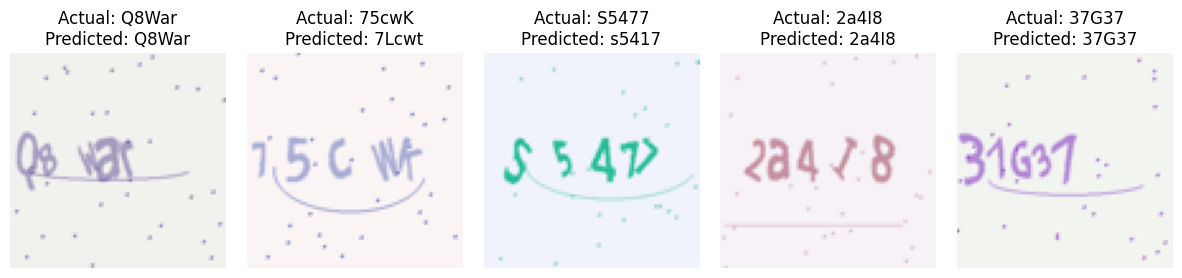

In [3]:
import matplotlib.pyplot as plt
from fastai.vision.all import PILImage

def display_predictions(learn_list, num_samples=5):
    test_df = df.sample(num_samples)
    n_cols = num_samples
    n_rows = 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(test_df.iterrows()):
        img_path = row['image']
        img = PILImage.create(img_path)
        
        img = img.resize((img.width // 3, img.height // 3))
        
        actual_labels = [row[f'label_{i+1}'] for i in range(5)]
        predicted_labels = []
        for i, learn in enumerate(learn_list):
            pred, _, _ = learn.predict(img)
            predicted_labels.append(pred)
        
        ax = axes[idx]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Actual: {''.join(actual_labels)}\nPredicted: {''.join(predicted_labels)}")
    
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

display_predictions(learn_list, num_samples=5)
